In [264]:
import torch
import torch.autograd
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from matplotlib import animation, rc
from IPython.display import HTML
from IPython import display
import ot
import ot.plot

In [265]:
def generateTheta(L,endim):
    # This function generates L random samples from the unit `ndim'-u
    theta=[w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L,endim))]
    return np.asarray(theta).T

def sw_dist(f, g):
    D = f.shape[1]
    L=100 # Number of random projections
    theta = torch.from_numpy(generateTheta(L, D))
    projg = torch.mm(g, theta)
    projg_sorted = torch.topk(projg, k=N, dim=0)[0]
    projf = torch.mm(f, theta)
    dist = torch.mean((torch.topk(projf, k=N, dim=0)[0] - projg_sorted)**2)
    return dist

def w2_dist(f, g):
    M = ot.dist(f.data.numpy(), g.data.numpy(), metric='sqeuclidean')
    G = ot.emd(a, b, M)
    ix1, ix2 = np.nonzero(G)
    dist = torch.mean(torch.sum((f - g[ix2])**2, dim=1))
    return dist

def sinkhorn_dist(f, g, reg):
    M = ot.dist(f.data.numpy(), g.data.numpy(), metric='sqeuclidean')
    G = ot.sinkhorn(a, b, M, reg=reg)
    ix2 = np.argmax(G, axis=1)
    dist = torch.mean(torch.sum((f - g[ix2])**2, dim=1))
    return dist

In [266]:
np.random.seed(12345)
N = 10
d = 2
a, b = np.ones((N,)) / N, np.ones((N,)) / N  # points have equal probability of 1/N
f0 = np.random.rand(N, 2) - .5;
theta = 2 * np.pi * np.random.rand(1, N)
r = .99 + .01 * np.random.randn(1, N)
g0 = np.vstack([np.cos(theta) * r, np.sin(theta) * r]).T

In [267]:
def f2g(dist_fn, ax, title, **kwargs):
    f = torch.from_numpy(f0.copy())
    f.requires_grad = True
    g = torch.from_numpy(g0.copy())

    ax.axis('equal')
    optimizer = optim.SGD([f], lr=1)
    imgs = []
    for i in range(10):
#         ax.cla()
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_title(title)
        img = ax.plot(f.data.numpy()[:, 0], f.data.numpy()[:, 1], 'bo',
                      g0[:, 0], g0[:, 1], 'ro')
        imgs.append(img)
        optimizer.zero_grad()
        dist = dist_fn(f, g, **kwargs)
        dist.backward()
        optimizer.step()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1e-3)
    return imgs

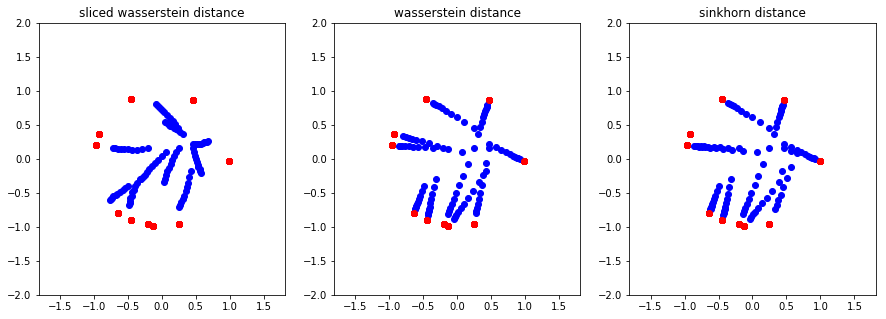

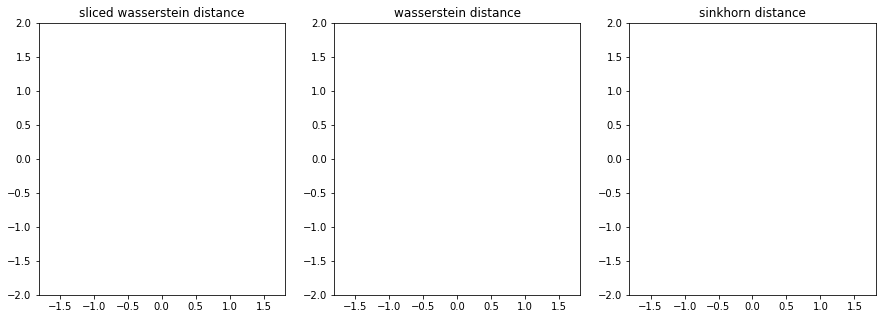

In [268]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
titles = ['sliced wasserstein distance', 'wasserstein distance', 'sinkhorn distance']
kwargs = [{}, {}, {'reg': 0.1}]
dist_fns = [sw_dist, w2_dist, sinkhorn_dist]
captures = []
for ax, dist_fn, title, args in zip(axes, dist_fns, titles, kwargs):
    frames = f2g(dist_fn, ax, title, **args)
    captures.append(frames)
frames = [f1 + f2 + f3 for f1, f2, f3 in zip(*captures)]
ani = animation.ArtistAnimation(fig, frames, interval=200, repeat=True)
HTML(ani.to_jshtml())


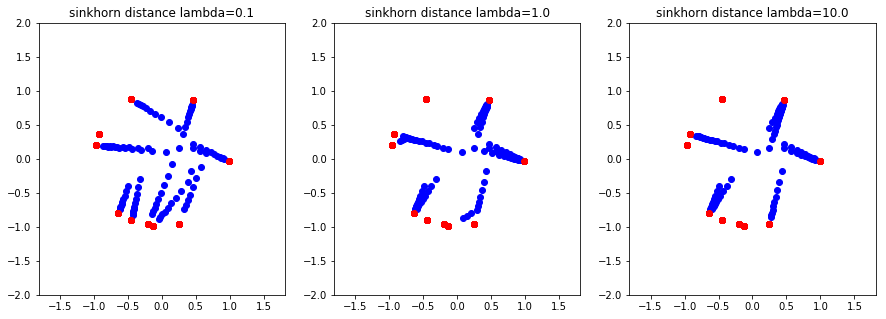

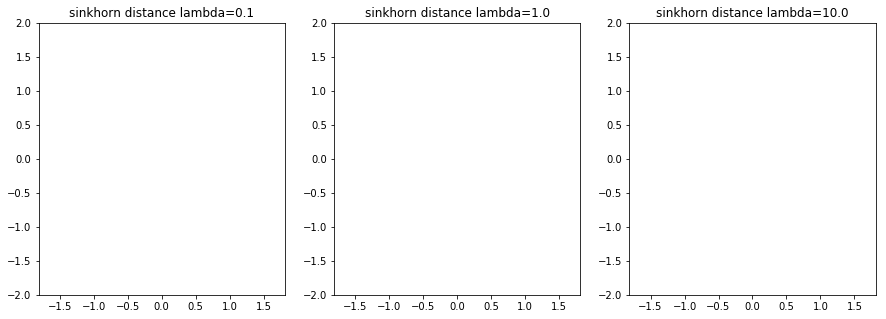

In [270]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
titles = ['sinkhorn distance lambda=0.1', 'sinkhorn distance lambda=1.0', 'sinkhorn distance lambda=10.0']
kwargs = [{'reg': 0.1}, {'reg': 1.0}, {'reg': 10}]
dist_fns = [sinkhorn_dist, sinkhorn_dist, sinkhorn_dist]
captures = []
for ax, dist_fn, title, args in zip(axes, dist_fns, titles, kwargs):
    frames = f2g(dist_fn, ax, title, **args)
    captures.append(frames)
frames = [f1 + f2 + f3 for f1, f2, f3 in zip(*captures)]
ani = animation.ArtistAnimation(fig, frames, interval=200, repeat=True)
HTML(ani.to_jshtml())

In [277]:
N = 500 # number of data points
a, b = np.ones((N,)) / N, np.ones((N,)) / N  # points have equal probability of 1/N
f = np.random.randn(N, 10) # dimension is 10000
g = np.random.randn(N, 10)
M = ot.dist(f, g, metric='sqeuclidean')

In [278]:
%timeit M = ot.dist(f, g, metric='sqeuclidean')

3.81 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [284]:
%timeit G = ot.sinkhorn(a, b, M, reg=1.0)

32.3 ms ± 8.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [285]:
%timeit G = ot.sinkhorn(a, b, M, reg=0.1)

139 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [286]:
%timeit G = ot.emd(a, b, M)

26.5 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
